In [1]:
import torch
import torch.nn as nn
from scipy import linalg
from torch.autograd import Variable
from torch.nn.functional import adaptive_avg_pool2d
from torchvision import models

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016,
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.01MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

torch.Size([1001])
torch.Size([1001])
torch.Size([1000])
torch.Size([1000])
Shape of beta (cosine_variance_schedule): torch.Size([1000])
Shape of f_t: torch.Size([1001])


Training:   0%|          | 0/23500 [00:00<?, ?it/s]

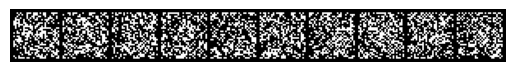

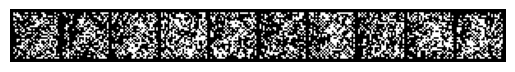

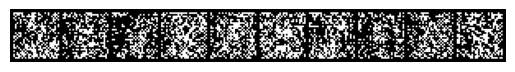

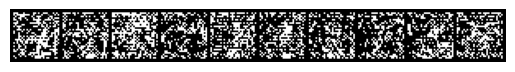

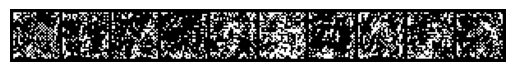

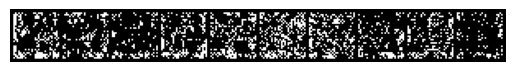

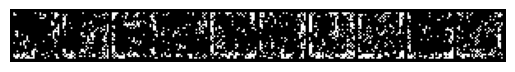

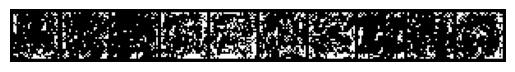

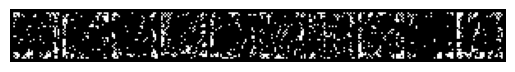

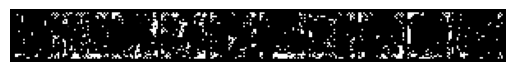

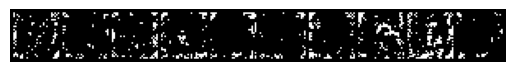

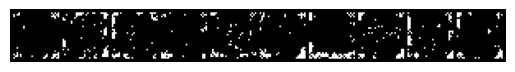

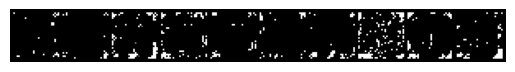

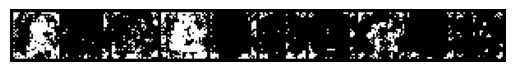

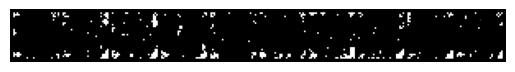

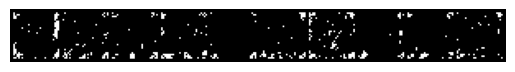

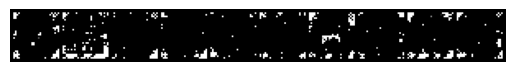

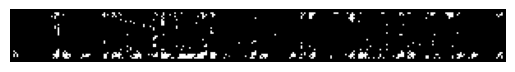

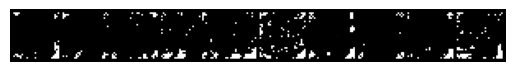

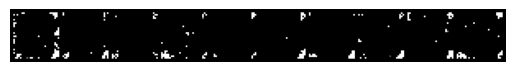

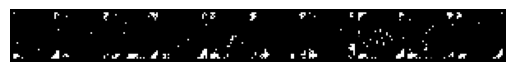

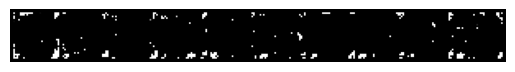

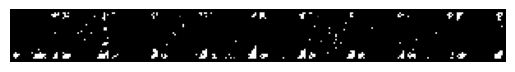

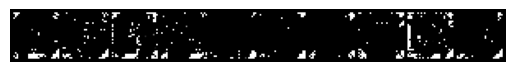

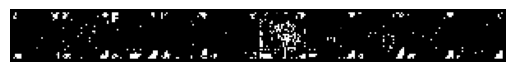

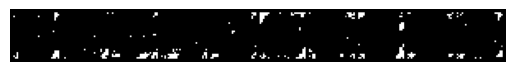

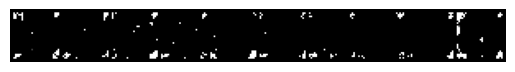

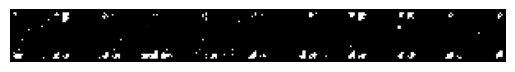

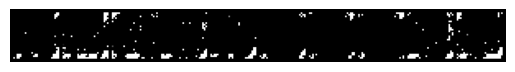

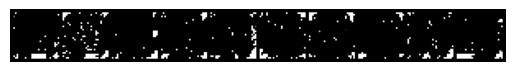

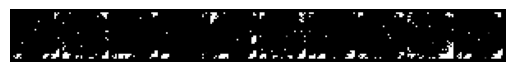

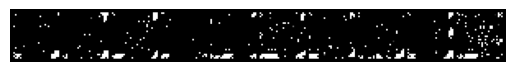

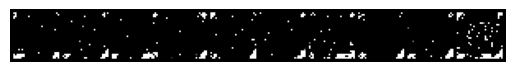

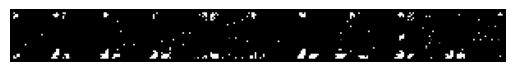

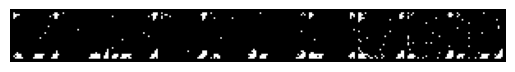

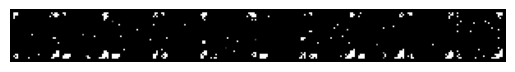

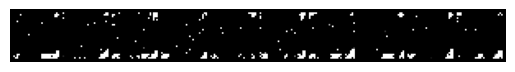

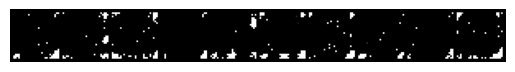

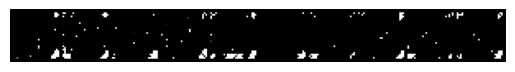

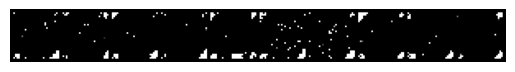

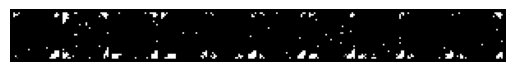

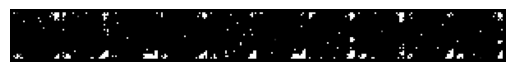

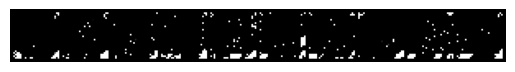

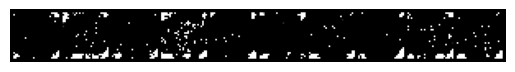

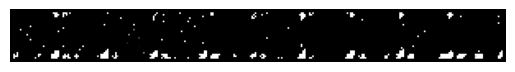

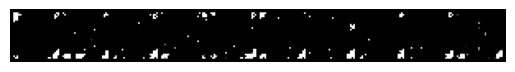

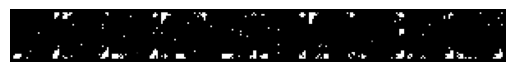

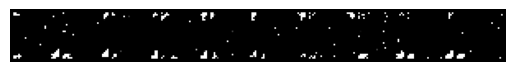

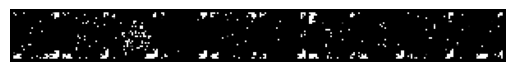

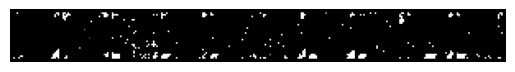

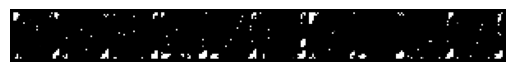

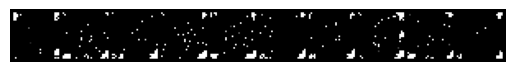

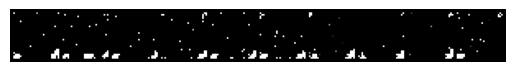

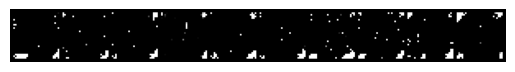

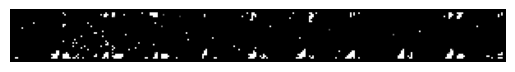

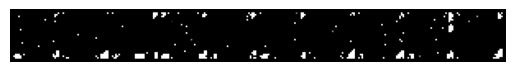

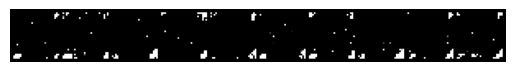

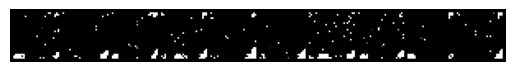

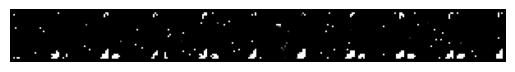

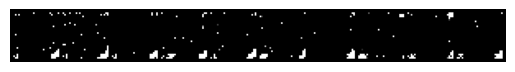

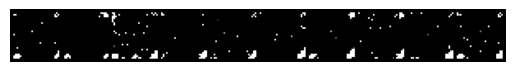

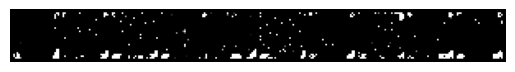

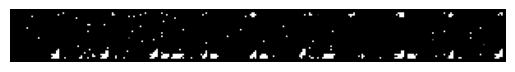

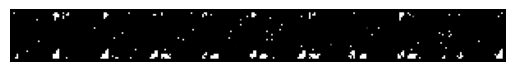

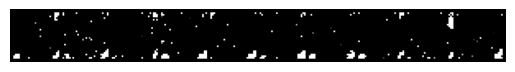

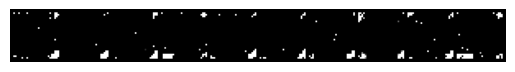

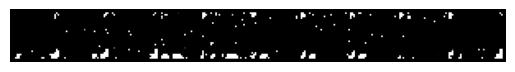

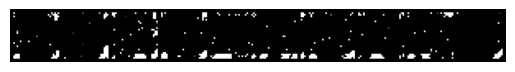

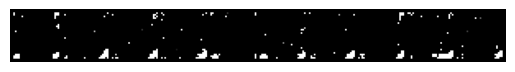

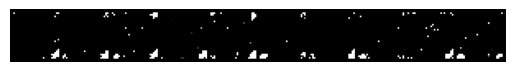

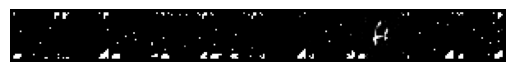

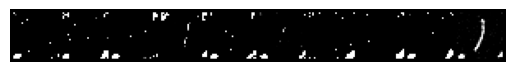

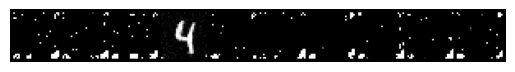

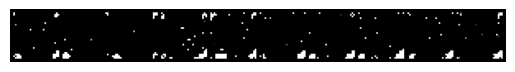

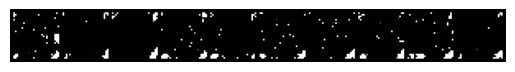

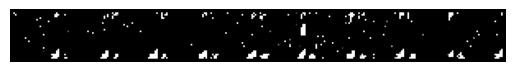

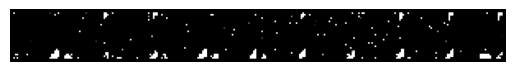

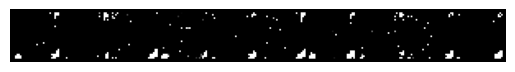

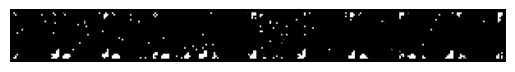

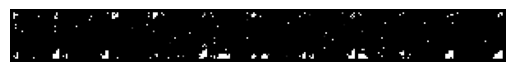

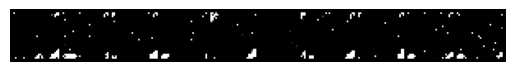

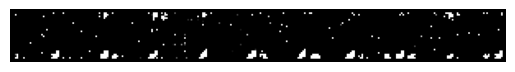

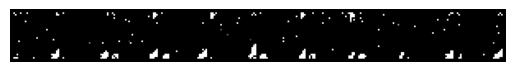

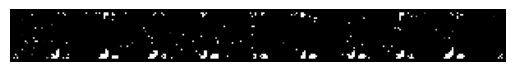

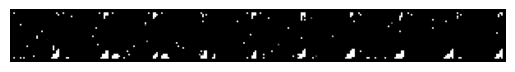

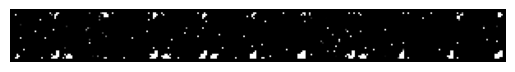

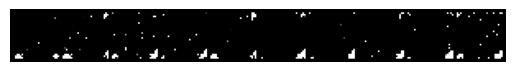

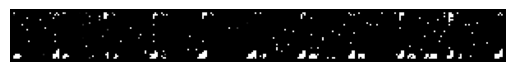

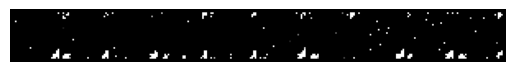

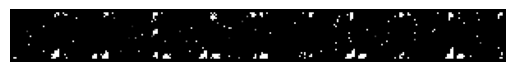

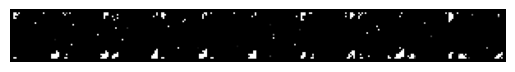

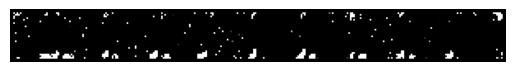

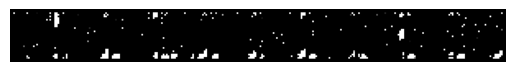

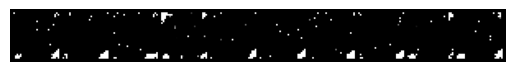

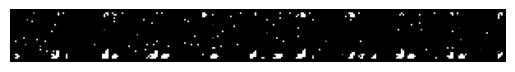

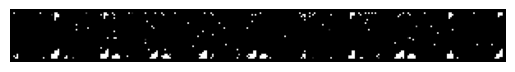

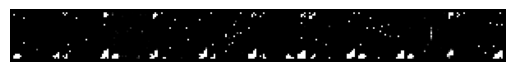

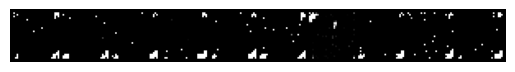

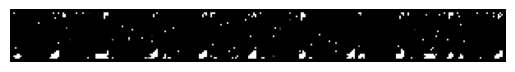

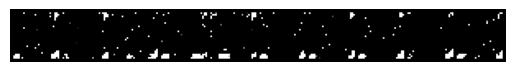

In [4]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Cosine variance schedule
        s = 0.008
        steps = torch.linspace(0, T, steps=T+1)
        f_t = torch.cos(((steps/T+s)/(1.0+s))*math.pi/2.)**2
        print(steps.shape)
        print(f_t.shape)
        print(f_t[1:].shape)
        print(f_t[:T].shape)
        cosine_variance_schedule = torch.clip(1.0-f_t[1:]/f_t[:-1],0.0,0.999)
        #print(cosine_variance_schedule)
        print(f"Shape of beta (cosine_variance_schedule): {cosine_variance_schedule.shape}")  # Should be [T]
        print(f"Shape of f_t: {f_t.shape}")  # Should be [T+1]
        cosine_variance_schedule = torch.cat((torch.tensor([s]), cosine_variance_schedule))
        #print(cosine_variance_schedule.shape)

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", cosine_variance_schedule)
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t))
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

        return mean + std*epsilon


    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt


    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))


    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop

    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()

# Call training loop
train(model, optimizer, scheduler, dataloader_train,
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)


The rest is added for comparison:

In [ ]:
def sample(model, sample_size):
    """Created function for sampling from the dataset y_prediction"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = sample_size
        samples = model.sample((nsamples,28*28))#.cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2
        samples = samples.clamp(0.0, 1.0)

    return samples

In [ ]:
y_true = dataloader_train.dataset.data.reshape(60000, 784)
y_true = y_true.to(device)
y_true = y_true.reshape(-1, 1, 28, 28)
y_true_3c = y_true.repeat(1, 3, 1, 1)

y_pred = sample(model.to(device), 10000)
y_pred = y_pred.reshape(-1, 1, 28, 28)
y_pred_3c = y_pred.repeat(1, 3, 1, 1)

In [ ]:
# from https://github.com/sbarratt/inception-score-pytorch/tree/master
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3, Inception_V3_Weights # added

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    # CHANGED
    inception_model = inception_v3(
                      weights=Inception_V3_Weights.IMAGENET1K_V1,  # or Inception_V3_Weights.DEFAULT
                      transform_input=False
                      ).type(dtype)

    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

if __name__ == '__main__':
    class IgnoreLabelDataset(torch.utils.data.Dataset):
        def __init__(self, orig):
            self.orig = orig

        def __getitem__(self, index):
            return self.orig[index][0]

        def __len__(self):
            return len(self.orig)

    import torchvision.datasets as dset
    import torchvision.transforms as transforms

    cifar = dset.CIFAR10(root='data/', download=True,
                             transform=transforms.Compose([
                                 transforms.Resize(32), # used to be .Scale
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ])
    )

    IgnoreLabelDataset(cifar)

    print ("Calculating Inception Score...")
    print (inception_score(IgnoreLabelDataset(cifar), cuda=True, batch_size=32, resize=True, splits=10))

Files already downloaded and verified
Calculating Inception Score...
(9.67277863501779, 0.14991474694795295)


In [ ]:
inception_score_pred = inception_score(y_pred_3c, cuda=True, batch_size=32, resize=True, splits=10)
inception_score_true = inception_score(y_true_3c, cuda=True, batch_size=32, resize=True, splits=10)

In [ ]:
print(inception_score_pred)
print(inception_score_true)

(1.8457181858420495, 0.034569895592393186)
(6.575426588552686, 0.08149018572398967)


## FID score

In [ ]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 cuda=False):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, normalizes the input to the statistics the pretrained
            Inception network expects
        requires_grad : bool
            If true, parameters of the model require gradient. Possibly useful
            for finetuning the network
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if cuda:
          dtype = torch.cuda.FloatTensor
        else:
          if torch.cuda.is_available():
            print("WARNING: switch to cuda")
          dtype = torch.FloatTensor

        inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1).type(dtype)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)

        if self.normalize_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

In [ ]:
def get_activations(images, model, batch_size=64, dims=2048,
                    cuda=False, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, 3, hi, wi). The values
                     must lie between 0 and 1.
    -- model       : Instance of inception model
    -- batch_size  : the images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size depends
                     on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    d0 = images.shape[0]
    if batch_size > d0:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = d0

    n_batches = d0 // batch_size
    n_used_imgs = n_batches * batch_size

    pred_arr = np.empty((n_used_imgs, dims))
    for i in range(n_batches):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i * batch_size
        end = start + batch_size

        batch = torch.from_numpy(images[start:end]).type(torch.FloatTensor)
        with torch.no_grad():
            batch = Variable(batch)
        if cuda:
            batch = batch.cuda()

        if batch.size()[1] == 1:
            batch = torch.cat((batch, batch, batch), 1)

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.shape[2] != 1 or pred.shape[3] != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(batch_size, -1)

    if verbose:
        print(' done')

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representive data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representive data set.

    Returns:
    --   : The Frechet Distance.
    """
    import time

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    start_time = time.time()

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            # raise ValueError('Imaginary component {}'.format(m))
            print('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_activation_statistics(images, model, batch_size=64,
                                    dims=2048, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, 3, hi, wi). The values
                     must lie between 0 and 1.
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(images, model, batch_size, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
cuda = True
pred_batch_size = 256
true_batch_size = 256
dims = 2048
incep_model = InceptionV3(cuda=cuda)

m1, s1 = calculate_activation_statistics(y_pred.cpu().numpy(), incep_model, pred_batch_size, dims, cuda, verbose=True)
m2, s2 = calculate_activation_statistics(y_true.cpu().numpy(), incep_model, true_batch_size, dims, cuda, verbose=True)
fid_value = calculate_frechet_distance(m1, s1, m2, s2)
fid_value

Propagating batch 39/39 done
Propagating batch 234/234 done


34745.78772184944

likelihood

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_elbo(model, x0):
    """
    Compute a simple approximation to the negative ELBO (i.e. an upper bound
    on -log p_\theta(x_0)) for a single batch x0.

    Parameters
    ----------
    model : DDPM
        Your DDPM instance (with forward_diffusion, network, etc.).
    x0 : torch.Tensor
        A batch of input images, shape (batch_size, 784) for MNIST.

    Returns
    -------
    torch.Tensor
        shape (batch_size,) with approximate -ELBO(x0).
        Summing / averaging gives your likelihood estimate.
    """

    device = x0.device
    batch_size = x0.shape[0]

    # Just for convenience
    T = model.T  # or pass T as a separate argument if needed

    #-----------------------------------------
    # 1. Generate the forward chain x_1..x_T
    #-----------------------------------------
    x = [x0]  # x[0] = x_0
    # We'll also store the noise eps_t used at each step for comparison
    epsilons = []
    for t_ in range(1, T+1):
        # Sample a random noise for this step
        epsilon = torch.randn_like(x0)
        epsilons.append(epsilon)

        # Create a timestep tensor with shape (batch_size, 1)
        t_tensor = torch.full((batch_size, 1), t_, device=device, dtype=torch.long)

        # Use the existing forward_diffusion function
        x_t = model.forward_diffusion(x[-1], t_tensor, epsilon)
        x.append(x_t)

    # x[1] is x_1, x[2] is x_2, ..., x[T] is x_T

    #-----------------------------------------
    # 2. Sum the MSE terms for t=1..T
    #    (the "simple objective" approximating each KL)
    #-----------------------------------------
    total_nll = torch.zeros(batch_size, device=device)  # accumulates -ELBO

    for t_ in range(1, T+1):
        xt = x[t_]           # shape: (batch_size, 784)
        eps_true = epsilons[t_-1]  # the actual noise used at this step

        # Predict the noise with the model's neural net:
        #  - model.network(...) expects (xt, t_normalized), but your code
        #    normalizes time by dividing by T inside the lambda
        eps_pred = model.network(xt, torch.full_like(xt[:, :1], fill_value=float(t_)))

        # Compute MSE between predicted and actual noise
        mse_t = F.mse_loss(eps_pred, eps_true, reduction='none')
        # shape: (batch_size, 784). We'll mean over features => (batch_size,)
        mse_t = mse_t.mean(dim=1)

        total_nll += mse_t   # Add the cost for this step

    #-----------------------------------------
    # 3. Final term: L_0 = -log p_theta(x0 | x1).
    #    Often approximated with MSE in "x_0-prediction" form.
    #-----------------------------------------
    x1 = x[1]  # shape: (batch_size, 784)

    # If we interpret model.network(x1, 1) as "predicted noise", that doesn't
    # directly give x0. We might do "x_0_hat = f( noise_pred, x1 )" or we
    # could param in a different way. Here is a simple example approach:

    # We'll do a naive approach: "predict x_0 from x_1" with the same network call,
    # but some folks have a specialized parameterization for L_0.
    # For demonstration, let's pretend the network *directly* outputs x0 at t=0.
    # (This is likely NOT how your code is set up, so adapt accordingly!)

    x0_hat = model.network(x1, torch.zeros_like(x1[:, :1]))  # "pretend" t=0 => just an example
    # MSE as a proxy for -log p_theta(x0 | x1)
    l0 = F.mse_loss(x0_hat, x0, reduction='none')
    l0 = l0.mean(dim=1)  # shape (batch_size,)

    total_nll += l0

    #-----------------------------------------
    # 4. Return the per-sample -ELBO
    #-----------------------------------------
    # You can do `return total_nll.mean()` if you want a single scalar,
    # but returning the full vector is sometimes helpful.
    return total_nll


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, 1]
    transforms.Lambda(lambda x: x.flatten())
])

# Create a test dataset
test_dataset = datasets.MNIST(
    root='./mnist_data',
    train=False,               # <--- IMPORTANT (test split)
    download=True,
    transform=transform
)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False              # typically False for test/eval
)


In [7]:
#model.eval()
#with torch.no_grad():
#    for x_batch, _ in test_loader:
#        x_batch = x_batch.to(device)
#        elbo_vals = compute_elbo(model, x_batch)
#        # Average or sum
#        nll = elbo_vals.mean()  # => scalar
#        print("Approx NLL:", nll.item())
#        break  # just one batch as an example

#for (x_batch, _) in test_dataloader:
#    x_batch = x_batch.to(device)
#    nll_estimate = compute_elbo(model, x_batch, T=model.T)
#    # e.g. average the result
#    avg_nll = nll_estimate.mean()
#    print("Approx. -log p(x):", avg_nll.item())

model.eval()
with torch.no_grad():
    total_nll = 0.0
    count = 0
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        # Suppose you have a compute_elbo function:
        elbo_vals = compute_elbo(model, x_batch)
        nll = elbo_vals.mean()
        total_nll += nll.item() * x_batch.size(0)
        count += x_batch.size(0)

    avg_nll = total_nll / count
    print(f"Approximate average NLL on test set: {avg_nll}")



Approximate average NLL on test set: 2535.062168359375
